In [5]:
import pandas as pd 
import plotly
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from sklearn.cluster import DBSCAN
import os
import sys


In [2]:

print(os.listdir("../data"))


['lidar_cable_points_extrahard.parquet', 'lidar_cable_points_medium.parquet', 'lidar_cable_points_hard.parquet', 'lidar_cable_points_easy.parquet']


In [ ]:
print(os.getcwd())
print(os.listdir("../src"))
sys.path.append(os.path.abspath("../src"))

/Users/grace/catenary-wire-modeling/notebooks
['clustering.py', 'models.py', '__pycache__']


## playground

In [7]:
cable_points_easy =  "../data/lidar_cable_points_easy.parquet"

In [8]:
df_easy = pd.read_parquet(cable_points_easy)
df_easy

,x,y,z
2211,6.196634,-13.157755,10.582272
2905,-10.440643,17.264460,10.926065
1411,2.977432,-3.552676,10.072814
251,5.924494,-10.974960,10.342501
794,-7.062873,12.850664,10.557997
...,...,...,...
1043,11.752706,-19.651017,11.259984
2498,-0.718055,-0.646010,10.018425
1938,-9.744563,19.548960,11.272980
1621,-2.060735,5.730059,10.090603


In [9]:
len(df_easy)

1502

In [10]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=df_easy['x'],
    y=df_easy['y'],
    z=df_easy['z'],
    mode='markers',
    marker=dict(
        size=1,
        opacity=0.7
    )
))

fig.update_layout(
    title='LiDAR Point Cloud Visualization',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        
        # aspectratio=dict(x=1, y=1, z=1),
        aspectmode='data', #Scaling axes according to actual data ranges
    )
)

fig.show()

In [11]:
points = df_easy[['x', 'y', 'z']].values


In [12]:
clustering = DBSCAN(eps=0.765, min_samples=8).fit(points)
df_easy['cluster'] = clustering.labels_

In [13]:
len(df_easy['cluster'].unique())
df_easy['cluster'].unique()

array([0, 1, 2])

In [14]:
fig = go.Figure()

for cluster_id in df_easy['cluster'].unique():
    cluster_data = df_easy[df_easy['cluster'] == cluster_id]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['x'],
        y=cluster_data['y'],
        z=cluster_data['z'],
        mode='markers',
        marker=dict(
            size=1.5,  # Smaller = sharper, better for thin wire visuals
            opacity=0.7
        ),
        name=f'Cluster {cluster_id}'
    ))

fig.update_layout(
    title='Clustered Wires (small points)',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    )
)
fig.show()

* not detecting regular shapes..
* could be bacuse of varying densities .. which is establish already as limitation for this algorithm


the steps ??:
* Flatten Each Cluster into a 2D Plane
* Fit a Catenary Curve 
* Map the Curve Back to 3D

#### PCA for flattenin to 2D:
* Axis 1 = direction of maximum spread (wire length),
* Axis 2 = direction of second-most spread (the curve/sag),
*  Axis 3 = direction orthogonal to the wire plane (which we drop)...

In [15]:

from sklearn.decomposition import PCA

cluster_0 = df_easy[df_easy['cluster'] == 0][['x', 'y', 'z']].values
pca = PCA(n_components=2)
points_2d = pca.fit_transform(cluster_0)





points_2d.shape


(492, 2)

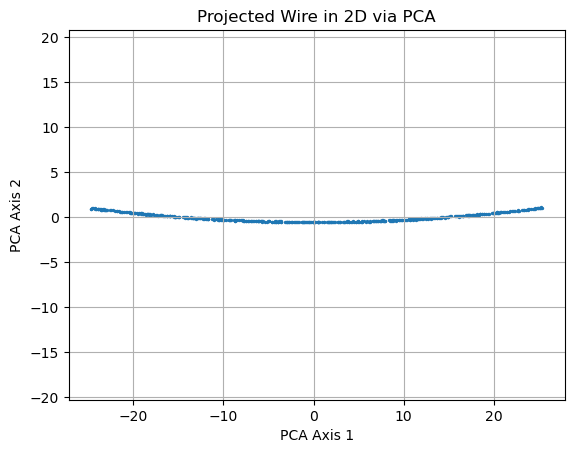

In [16]:
# checking if the PCA might rotate the 2D axes arbitrarily
import matplotlib.pyplot as plt

plt.scatter(points_2d[:, 0], points_2d[:, 1], s=2)
plt.title("Projected Wire in 2D via PCA")
plt.xlabel("PCA Axis 1")
plt.ylabel("PCA Axis 2")
plt.axis('equal')
plt.grid(True)
plt.show()

In [17]:
# Sort the 2D wire points before fitting
sorted_idx = np.argsort(points_2d[:, 0])
points_2d = points_2d[sorted_idx]

In [18]:
from scipy.optimize import curve_fit

def catenary(x, x0, y0, c):
    return y0 + c * (np.cosh((x - x0) / c) - 1)

In [19]:
x_data = points_2d[:, 0]
y_data = points_2d[:, 1]

init_params = [np.mean(x_data), np.min(y_data), 1.0]  # Start fitting near the middle of the wire
params, _ = curve_fit(catenary, x_data, y_data, p0=init_params)




/var/folders/cw/0t2jzw0d1dg1rj3qj57z9_qh0000gn/T/ipykernel_24634/678254232.py:5: OptimizeWarning:

Covariance of the parameters could not be estimated



     optimizer couldn’t estimate how uncertain those parameters are..?

In [20]:
x_fit = np.linspace(np.min(x_data), np.max(x_data), 492)
y_fit = catenary(x_fit, *params)

In [21]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_data, y=y_data,
    mode='markers',
    name='Original Wire',
    marker=dict(size=3, color='blue')
))


fig.add_trace(go.Scatter(
    x=x_fit, y=y_fit,
    mode='lines',
    name='Fitted Catenary',
    line=dict(color='red', width=2)
))

fig.update_layout(
    title="2D Catenary Curve Fit (Flattened Wire)",
    xaxis_title="x (along wire)",
    yaxis_title="y (sag)",
    width=800,
    height=500,
    template="plotly_white"
)

fig.show()

In [22]:
points_fit_2d = np.column_stack((x_fit, y_fit))

points_fit_2d.shape

(492, 2)

In [23]:
points_fit_3d = pca.inverse_transform(points_fit_2d)


In [24]:

scatter = go.Scatter3d(
    x=df_easy[df_easy['cluster'] == 0]['x'],
    y=df_easy[df_easy['cluster'] == 0]['y'],
    z=df_easy[df_easy['cluster'] == 0]['z'],
    mode='markers',
    marker=dict(
        size=2,
        color='blue', 
        opacity=0.7
    ),
    name='Original Points'
)

# Fitted catenary curve in 3D
catenary_curve = go.Scatter3d(
    x=points_fit_3d[:, 0],
    y=points_fit_3d[:, 1],
    z=points_fit_3d[:, 2],
    mode='lines',
    line=dict(color='red', width=4),
    name='Fitted Catenary Curve'
)

layout = go.Layout(
    title='LiDAR Wire with Fitted 3D Catenary Curve',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',

    ),
    legend=dict(x=0, y=1)
)

fig = go.Figure(data=[scatter, catenary_curve], layout=layout)
fig.show()


In [25]:

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_data,
    y=y_data - y_fit, #residuals
    mode='markers',
    marker=dict(color='blue', size=4),
    name='Residuals'
))

# Horizontal line at y=0
fig.add_trace(go.Scatter(
    x=[np.min(x_data), np.max(x_data)],
    y=[0, 0],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Zero Line'
))


fig.update_layout(
    title='Residual Plot (Catenary Fit)',
    xaxis_title='x (along wire)',
    yaxis_title='Residual (y_true - y_fit)',
    width=800,
    height=500
)

fig.show()


## explore other data 

In [42]:
files = {
    "Easy": "../data/lidar_cable_points_easy.parquet",
    "Medium": "../data/lidar_cable_points_medium.parquet",
    "Hard": "../data/lidar_cable_points_hard.parquet",
    "Extra Hard": "../data/lidar_cable_points_extrahard.parquet"
}

colors_list = ["green", "blue", "orange", "red"]
colors = {
    "Easy": "green",
    "Medium": "blue",
    "Hard": "orange",
    "Extra Hard": "red"
}

In [69]:



traces = []
for i, (label, path) in enumerate(files.items()):
    df = pd.read_parquet(path)
    traces.append(go.Scatter3d(
        x=df['x'], y=df['y'], z=df['z'],
        mode='markers',
        marker=dict(size=1.5, color=colors_list[i]),
        name=label
    ))


fig = go.Figure(data=traces)
fig.update_layout(
    title="LiDAR Point Clouds: Easy → Extra Hard",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z', 
        # aspectmode='data'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


 
* **big-picture sanity check** :  seperation between clusters is visible &rarr; good candidates for DBSCAN or HDBSCAN clustering..


In [68]:
for label, path in files.items():
    df = pd.read_parquet(path)
    
    fig = go.Figure(data=[go.Scatter3d(
        x=df['x'], y=df['y'], z=df['z'],
        mode='markers',
        marker=dict(size=1.5, color=colors[label]),
        name=label
    )])
    
    fig.update_layout(
        title=f"LiDAR Point Cloud - {label}",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z', 
            aspectmode='data'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    
    fig.show()

## fit whole data/per cluster

In [ ]:
from catenary_models import *


In [28]:
df_easy


,x,y,z,cluster
2211,6.196634,-13.157755,10.582272,0
2905,-10.440643,17.264460,10.926065,0
1411,2.977432,-3.552676,10.072814,1
251,5.924494,-10.974960,10.342501,2
794,-7.062873,12.850664,10.557997,2
...,...,...,...,...
1043,11.752706,-19.651017,11.259984,1
2498,-0.718055,-0.646010,10.018425,0
1938,-9.744563,19.548960,11.272980,1
1621,-2.060735,5.730059,10.090603,1


In [29]:
fig = go.Figure()

for cluster_id in df_easy['cluster'].unique():
    wire_points = df_easy[df_easy['cluster'] == cluster_id][['x', 'y', 'z']].values
    result = fit_catenary_to_cluster(wire_points)

    if result:
        points_fit_3d, _ = result

        # Plot original LiDAR points
        fig.add_trace(go.Scatter3d(
            x=wire_points[:, 0],
            y=wire_points[:, 1],
            z=wire_points[:, 2],
            mode='markers',
            marker=dict(size=2, opacity=0.4),
            name=f"Cluster {cluster_id} - raw"
        ))

        # Plot fitted catenary curve
        fig.add_trace(go.Scatter3d(
            x=points_fit_3d[:, 0],
            y=points_fit_3d[:, 1],
            z=points_fit_3d[:, 2],
            mode='lines',
            line=dict(width=4),
            name=f"Cluster {cluster_id} - fit"
        ))

fig.update_layout(
    title="Fitted Catenary Curves for Each Wire",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        # aspectmode='data'  
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


/Users/grace/catenary-wire-modeling/src/models.py:49: OptimizeWarning:

Covariance of the parameters could not be estimated



not so reliable ? 
* There aren’t enough points
* The wire is too straight or weirdly shaped
* The starting guess was off

In [57]:
cable_points_medium =  "../data/lidar_cable_points_medium.parquet"

In [72]:
df_medium = pd.read_parquet(cable_points_medium)


In [77]:
points3d_medium =  df_medium[['x', 'y','z']].values

labels_medium =  cluster_points_dbscan(points3d_medium)

df_medium['cluster'] = labels_medium

In [78]:
len(df_medium['cluster'].unique())

18

## Hdbscan clustering

In [140]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10)

In [141]:
clusterer.fit(points3d_medium)

/Users/grace/miniconda3/envs/backup_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/grace/miniconda3/envs/backup_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



,min_cluster_size,50
,min_samples,10
,cluster_selection_epsilon,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)
,approx_min_span_tree,True


In [142]:
clusterer.labels_

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:

from importlib import reload
reload(clustering)

from notebooks.clustering import cluster_points_dbscan, plot_clusters_3d


In [144]:
plot_clusters_3d(points3d_medium, clusterer.labels_)

In [113]:
plot_clusters_3d(points, df_easy['cluster'])

In [114]:
# cluster hard data

df_hard = pd.read_parquet("../data/lidar_cable_points_hard.parquet")

# df_hard.values.shape
clusturer_hard = hdbscan.HDBSCAN().fit(df_hard.values)

labels_hard = clusturer_hard.labels_

/Users/grace/miniconda3/envs/backup_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/grace/miniconda3/envs/backup_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [115]:
plot_clusters_3d(df_hard.values, labels_hard)

In [116]:
df_extrahard = pd.read_parquet("../data/lidar_cable_points_extrahard.parquet")

# df_hard.values.shape
clusturer_extrahard = hdbscan.HDBSCAN().fit(df_extrahard.values)

labels_extrahard = clusturer_extrahard.labels_

/Users/grace/miniconda3/envs/backup_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/grace/miniconda3/envs/backup_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [118]:
plot_clusters_3d(df_extrahard.values, labels_extrahard)

## OPTICS clustering..

In [211]:
from sklearn.cluster import OPTICS

optics_clusterer_medium = OPTICS(min_samples=8, xi=0.03).fit(points3d_medium)
optics_labels_medium = optics_clusterer_medium.labels_

In [212]:
plot_clusters_3d(points3d_medium, optics_labels_medium)

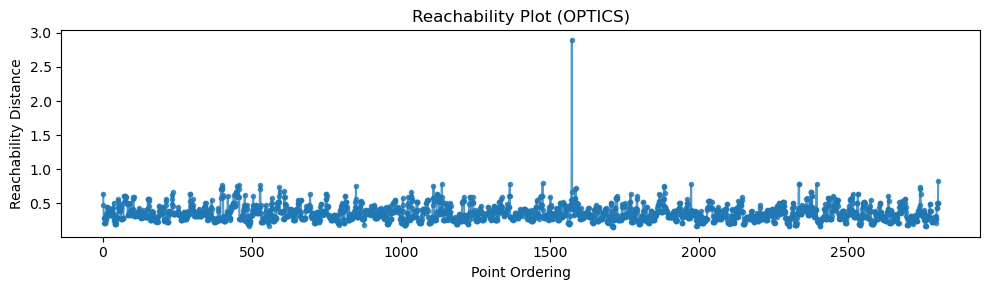

In [ ]:
#how OPTICS sees the density structure:

import matplotlib.pyplot as plt

space = np.arange(len(points3d_medium))
reachability = optics_clusterer_medium.reachability_[optics_clusterer_medium.ordering_]

plt.figure(figsize=(10, 3))
plt.plot(space, reachability, marker='.', alpha=0.75)
plt.title('Reachability Plot (OPTICS)')
plt.ylabel('Reachability Distance')
plt.xlabel('Point Ordering')
plt.tight_layout()
plt.show()

In [202]:
points3d_medium.shape

(2803, 3)

## spectral clustering


In [223]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(
    
    random_state=123
)

spectral_labels_medium = sc.fit_predict(points3d_medium)

In [224]:
plot_clusters_3d(points3d_medium,spectral_labels_medium )

## clustering using deep models ? 


In [4]:
import open3d as o3d

In [41]:
df_hard =  pd.read_parquet("../data/lidar_cable_points_hard.parquet")
points = df_hard[['x', 'y', 'z']].values

# create point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)


In [40]:
o3d.visualization.draw_geometries([pcd])

In [42]:
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=16),
    fast_normal_computation=True
)


In [43]:
labels = np.array(pcd.cluster_dbscan(eps=0.765, min_points=8))


In [ ]:
from notebooks.clustering import plot_clusters_3d
plot_clusters_3d(points, labels)

In [ ]:
from catenary_models import project_to_2d
points_2d, pca = project_to_2d(points)

db = DBSCAN(eps=0.5, min_samples=3)
labels = db.fit_predict(points_2d)

In [77]:
labels.max()

55

In [78]:
plot_clusters_3d(points, labels)